In [1]:
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from feature_process import *
import joblib
import numpy as np
import os

## Classify/Regression

In [11]:
np.int(np.round(0.05 / (1 / 100)) * 2 - 1)

9

In [2]:
root = r'../final_data/mix_landmark5/'
train_type = 'clf0'

motion_score = []

In [3]:
def assign_label(feat, motions, motion_score, treatment, usage='clf0'):
    if usage=='clf0':
        labels = np.zeros_like(feat[:,0], dtype=int)
        if treatment == 'pH5.2':
            labels[:] = 2
        elif treatment == 'pH7.4':
            labels[:] = 0
        elif treatment == 'basal':
            labels[:] = 0
        elif treatment == 'Cap':
            labels[:] = 1
    elif usage=='reg2':
        labels = np.zeros_like(feat[:,0], dtype=int)
        if treatment == 'pH5.2':
            labels[:] = 1
        elif treatment == 'pH7.4':
            labels[:] = -1
        elif treatment == 'Cap':
            labels[:] = 1
        elif treatment == 'basal':
            labels[:] = -1
    return labels

In [4]:
x = []
y = []
treatments = []
files = os.listdir(root)
for file in files:
    dlc1 = dlc(root+file, True, 5)
    # feat = count_dist(dlc1.raw) # feature from landmark 7 
    feat = combine_feat(dlc1, sel_dist=[[0,3],[3,4],[1,2]], sel_ang=[[0,1,3],[1,3,4]], sel_coord=[], normalize=[0,1], index=False)

    x.append(feat)
    treatment = file.split('-')[0]
    if file.find('basal')!=-1:
        y.append(assign_label(feat, [], motion_score, 'basal', train_type))
        treatments.append(treatment+'basal')
    else:
        y.append(assign_label(feat, [], motion_score, treatment, train_type))
        treatments.append(treatment)
feat_dim = x[0].shape[1]
x=np.array(x,dtype=object)
y=np.array(y,dtype=object)

In [5]:
# data index of different treatments
basal_ind = [i for i, j in enumerate(treatments) if j.find('basal')!=-1]
pain_ind = [i for i, j in enumerate(treatments) if j == 'Cap']
sng_ind = [i for i, j in enumerate(treatments) if j == 'pH5.2']
ro_ind = [i for i, j in enumerate(treatments) if j == 'pH7.4']
print('basal:',len(basal_ind),' ,pain:',len(pain_ind),' sng:',len(sng_ind),' pH7.4:',len(ro_ind))
# setting training set index
trainset = list(set(basal_ind) | set(pain_ind) | set(sng_ind))
# trainset = list(set(basal_ind) | set(pain_ind))

basal: 41  ,pain: 15  sng: 14  pH7.4: 12


In [7]:
x_trains = []
y_trains = []
x_tests = []
y_tests = []
shuffles = [] #shuffle for fixed train test split
for i in range(len(x)):
    feat = x[i]
    label = y[i]

    if i in trainset and treatments[i].find('pH7.4')==-1:
        #shuffle
        ind = np.arange(len(feat))
        np.random.shuffle(ind)
        shuffles.append(ind)
        feat = feat[ind]
        #train test split
        sp = len(feat)//10
        if treatments[i].find('pH7.4')!=-1:
            # sp = len(feat)//10
        x_trains.append(feat[:sp,:])
        y_trains.append(label[:sp])
        x_tests.append(feat[sp:,:])
        y_tests.append(label[sp:])
    else:
        shuffles.append([])
        x_trains.append([])
        y_trains.append([])
        x_tests.append(feat)
        y_tests.append(label)

x_train = np.concatenate([x for x in x_trains if len(x) != 0])
y_train = np.concatenate([y for y in y_trains if len(y) != 0])
print('labels:', np.unique(y_train))

labels: [0 1 2]


### Classfy

In [8]:
# training model
model = SVC(kernel='rbf', C=1000)
model = model.fit(x_train,y_train)
# joblib.dump(model,'../final_data/models/f20.mcclf')

Cap train accuracy =  0.7021691811153644
pH5.2 train accuracy =  0.7040116645649432
Cap test accuracy =  0.6963645758671845
pH5.2 test accuracy =  0.6903909607288832
pH7.4 test accuracy =  0.8552797686919694


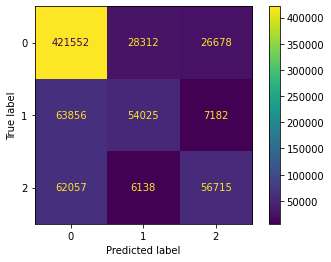

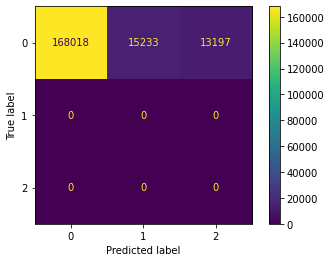

In [9]:
# training dataset testing
for t in ['Cap', 'pH5.2']:
    feats = []
    labels = []
    for i in range(len(x)):
        if treatments[i].find(t)!=-1:
            feats.append(x_trains[i])
            labels.append(y_trains[i])
    feat = np.concatenate(feats)
    label = np.concatenate(labels)
    # print(len(feats))
    print(t+' train accuracy = ', model.score(feat,label))
# testing dataset testing
for t in ['Cap', 'pH5.2', 'pH7.4']:
    feats = []
    labels = []
    for i in range(len(x)):
        if treatments[i].find(t)!=-1:
            feats.append(x_tests[i])
            labels.append(y_tests[i])
    # print(len(feats))
    feat = np.concatenate(feats)
    label = np.concatenate(labels)
    print(t+' test accuracy = ', model.score(feat,label))
# ALL confusion matrix 
feat = np.concatenate(x)
label = np.concatenate(y)
pred = model.predict(feat)
cm = confusion_matrix(label, pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
# pH7.4 confusion matrix
feats = []
labels = []
for i in range(len(x)):
    if treatments[i].find('pH7.4')!=-1:
        feats.append(x_tests[i])
        labels.append(y_tests[i])
feat = np.concatenate(feats)
label = np.concatenate(labels)
pred = model.predict(feat)
cm = confusion_matrix(label, pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()

### unseen data

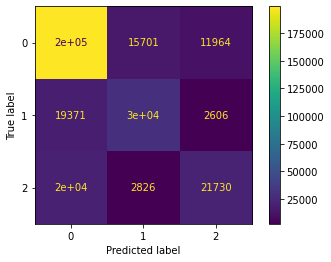

In [12]:
root = r'../final_data/old1_landmark5/'

x_t = []
y_t = []
treatments_t = []
files = os.listdir(root)
for file in files:
    dlc1 = dlc(root+file, True, 5)
    # feat = count_dist(dlc1.raw) # feature from landmark 7 
    feat = combine_feat(dlc1, sel_dist=[[0,3],[3,4],[1,2]], sel_ang=[[0,1,3],[1,3,4]], sel_coord=[], normalize=[0,1], index=False)

    x_t.append(feat)
    treatment = file.split('-')[0]
    if file.find('basal')!=-1:
        y_t.append(assign_label(feat, [], motion_score, 'basal', train_type))
        treatments_t.append(treatment+'basal')
    else:
        y_t.append(assign_label(feat, [], motion_score, treatment, train_type))
        treatments_t.append(treatment)
feat_dim = x[0].shape[1]
x_t=np.array(x_t,dtype=object)
y_t=np.array(y_t,dtype=object)

# ALL confusion matrix 
feat = np.concatenate(x_t)
label = np.concatenate(y_t)
pred = model.predict(feat)
cm = confusion_matrix(label, pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()